# Snippets

## This file houses important bits and pieces of the code used (or not) in my scripts for this project

Contains solutions to various problems I encountered, for future reference.

### This notebook is NOT intended to be run. This is just a scratchpad (working code only).

In [3]:
import pandas as pd
import numpy as np
import datetime
import pickle

pd.options.display.max_rows = 60
pd.options.display.max_columns = 60

In [4]:
DATE_FMT = "%Y-%m-%d"
AOD = '2017-08-01'
AOD_str = pd.to_datetime(AOD, format=DATE_FMT)

h1_res = pd.read_pickle("pickle/h1_res.pick")
h2_res = pd.read_pickle("pickle/h2_res.pick")
h1_dbd = pd.read_pickle("pickle/h1_dbd.pick")
h2_dbd = pd.read_pickle("pickle/h2_dbd.pick")
h1_sim = pd.read_pickle("pickle/h1_sim.pick")
h2_sim = pd.read_pickle("pickle/h2_sim.pick")

## Get the last day of the week for a series of dates (fully vectorized)

In [ ]:
df_sim["WeekEndDate"] = df_sim.apply(
        lambda x: x["Date"] + pd.DateOffset(weekday=6), axis=1
    )

## Estimate selling prices

In [ ]:
def rate_mapper(night):
    mask = (
        (df_res.ArrivalDate <= night)
        & (df_res.CheckoutDate > night)
        & (df_res.CustomerType == "Transient")
    )
    df_pricing_res = df_res[mask].copy()
    price = round(df_pricing_res[mask].ADR.mean(), 2)
    return price

df_sim["SellingPrice"] = df_sim["Date"].map(rate_mapper)

return df_res

## Estimate selling price (as of a given date) using only actualized reservations (WD/WE Pricing)

In [ ]:
def add_pricing(df_sim):
    """
    Adds 'SellingPrice' column to df_sim.

    Contains the average rate for all booked reservations during a given week (WD/WE).
    This gives us an indication of what the hotel's online selling prices.
    """
    # get average WD/WE pricing for each week
    df_sim.index = pd.to_datetime(df_sim.index, format="%Y-%m-%d")
    df_pricing = (
        df_sim[["Trn_RoomsOTB", "Trn_RevOTB", "WD"]]
        .groupby([pd.Grouper(freq="1W"), "WD"])
        .agg("sum")
    )
    df_pricing = df_pricing.reset_index().rename(columns={"level_0": "Date"})
    df_pricing["Date"] = pd.to_datetime(df_pricing.Date, format="%Y-%m-%d")
    df_pricing["Trn_ADR_OTB"] = round(
        df_pricing.Trn_RevOTB / df_pricing.Trn_RoomsOTB, 2
    )
    df_pricing.index = df_pricing.Date


    df_sim["Date"] = df_sim.index
    # have to do it this way to prevent performance warning (non-vectorized operation)
    df_sim["WeekEndDate"] = df_sim.apply(
        lambda x: x["Date"] + pd.DateOffset(weekday=6), axis=1
    )

    # apply the weekly WD/WE prices to the original df_sim
    def apply_rates(row):
        wd = row["WD"] == 1
        date = datetime.datetime.strftime(row.name, format="%Y-%m-%d")
        week_end = datetime.datetime.strftime(row.WeekEndDate, format="%Y-%m-%d")
        mask = df_pricing.WD == wd
        price = df_pricing[mask].loc[week_end, "Trn_ADR_OTB"]
        return price

    df_sim["SellingPrice"] = df_sim.apply(apply_rates, axis=1)

    return df_sim

## Filter for future reservations as of a given date

This cell runs if you ran the top two Python cells.

In [7]:
as_of_date="2017-08-16"
h1_res['ReservationStatusDate'] = pd.to_datetime(h1_res.ReservationStatusDate)
otb_mask = (
    (h1_res.ResMadeDate <= as_of_date)  # reservations made before AOD
    & (h1_res.CheckoutDate > as_of_date)  # checking out after AOD
) & (
    (h1_res.IsCanceled == 0)
    | (
        (  # only include cxls that have not been canceled yet
            (h1_res.IsCanceled == 1) & (h1_res.ReservationStatusDate >= as_of_date)
        )
    )
)
h1_res_aod = h1_res[otb_mask][['IsCanceled', 'ArrivalDate', 'CheckoutDate', 'ResMadeDate', 'ReservationStatus', 'ReservationStatusDate']]
h1_res_aod.sort_values('ReservationStatusDate', ascending=False, inplace=True)
h1_res_aod.sample(10)



,IsCanceled,ArrivalDate,CheckoutDate,ResMadeDate,ReservationStatus,ReservationStatusDate
40059,0,2017-08-31,2017-09-14,2017-03-23,Check-Out,2017-09-14
40058,0,2017-08-31,2017-09-14,2017-02-01,Check-Out,2017-09-14
40057,0,2017-08-29,2017-09-12,2017-02-06,Check-Out,2017-09-12


## Generate a list of dates from d1 to d2 (inclusive)

In [3]:
import datetime
d1 = datetime.date(2020, 1, 1)
d2 = datetime.date(2020, 4, 1)
all_dates = [datetime.datetime.strftime(d1 + datetime.timedelta(days=x), format="%Y-%m-%d") for x in range((d2-d1).days + 1)]
all_dates[:5]

['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05']

## Add CheckoutDate

In [ ]:
checkout_lam = lambda row: row["ArrivalDate"] + pd.DateOffset(row["LOS"])
df_res["CheckoutDate"] = df_res.apply(checkout_lam, axis=1)

## Get Same-Time-Last Year Date (same weekday)

In [ ]:
# this is how we can get the STLY of a given date (today, for example)
NOW = datetime.now()
STLY_weekday = NOW+relativedelta(years=-1, weekday=2)
print(STLY_weekday)

In [ ]:
# and in pandas
ty_dates = pd.to_datetime(h1_dbd.index)
stly_lambda = lambda x: x + relativedelta(years=-1, weekday=x.weekday())
stly = ty_dates.map(stly_lambda)
h1_dbd["STLY_Date"] = pd.to_datetime(stly, format="%Y-%m-%d")

## One-Hot encode a variable in a way that can be repeated with different values

In [ ]:
# one-hot-encode Country
top_ten_countries = list(
    df_res.Country.value_counts().sort_values(ascending=False).head(10).index
)

for country in top_ten_countries:
    df_res["FROM_" + country] = df_res.Country == country

df_res["FROM_other"] = ~df_res.Country.isin(top_ten_countries)

## Converting Reservations DataFrame --> Hotel DayByDays

Known inefficiency: I am going back 60 nights for each arrival date, when that's probably not necessary, per below histograms. However, I am going back as far as the maximum LOS in the dataset, so if I don't go back that far, I will miss it. 

A potential solution would be to create a sparse matrix containing reservation_ids and a list of their indices in a vectorized representation of reservation nights. Like so:

```
# dense matrix

[['res_id', '2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06'],
 ['000000', 1, 1, 0, 0, 0, 0],
 ['000001', 0, 0, 1, 1, 1, 1],
 ['000002', 0, 1, 0, 0, 0, 0]]

# sparse matrix
[('000000', '2020-01-01', '2020-01-02'),
 ('000001', '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06'),
 ('000002', '2020-01-02')]
```

I will add this to my list for things to do after the presentation, but for now, need to push onwards!

(array([2.9455e+04, 9.5120e+03, 9.2400e+02, 1.1300e+02, 4.0000e+01,
        6.0000e+00, 6.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([ 0. ,  6.9, 13.8, 20.7, 27.6, 34.5, 41.4, 48.3, 55.2, 62.1, 69. ]),
 <BarContainer object of 10 artists>)

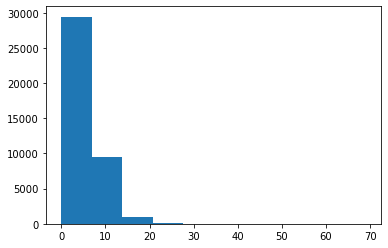

In [3]:
import matplotlib.pyplot as plt
h1_res = pd.read_pickle("pickle/h1_res.pick")

plt.hist(h1_res.LOS)

(array([7.3964e+04, 4.9970e+03, 2.7300e+02, 4.9000e+01, 2.1000e+01,
        2.2000e+01, 0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([ 0. ,  5.7, 11.4, 17.1, 22.8, 28.5, 34.2, 39.9, 45.6, 51.3, 57. ]),
 <BarContainer object of 10 artists>)

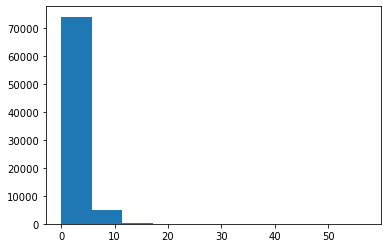

In [4]:
h2_res = pd.read_pickle("pickle/h2_res.pick")

plt.hist(h2_res.LOS)

In [ ]:
def res_to_dbd(df_res):
    """
    Takes a dataFrame (with parsed dates and LOS column) containing a hotel's reservations and
    returns a DataFrame containing nightly hotel room sales.

    Our data is made up of reservations containing 'Arrival Date' and 'Length of Stay'.
    This function is used to determine how many rooms were sold on a given night, accounting for
    guests that arrived previously and are staying multiple nights.
    """
    mask = df_res["IsCanceled"] == 0
    df_dates = df_res[mask]

    date = datetime.date(2015, 7, 1)
    end_date = datetime.date(2017, 8, 31)
    delta = datetime.timedelta(days=1)
    max_los = int(df_dates["LOS"].max())

    nightly_stats = {}

    while date <= end_date:

        date_string = datetime.datetime.strftime(date, format="%Y-%m-%d")
        tminus = 0

        # initialize date dict, which will go into nightly_stats as {'date': {'stat': 'val', 'stat', 'val'}}
        date_stats = defaultdict(int)

        # start on the arrival date and move back
        # to capture ALL reservations touching 'date' (and not just those that arrive on 'date')
        for _ in range(max_los):

            #
            date_tminus = date - pd.DateOffset(tminus)

            date_tminus_string = datetime.datetime.strftime(
                date_tminus, format="%Y-%m-%d"
            )

            mask = (
                (df_dates.ArrivalDate == date_tminus_string)
                & (df_dates.LOS >= 1 + tminus)
                & (df_dates.IsCanceled == 0)
            )

            date_stats["RoomsSold"] += len(df_dates[mask])
            date_stats["RoomRev"] += df_dates[mask].ADR.sum()

            tmp = (
                df_dates[mask][["ResNum", "CustomerType", "ADR"]]
                .groupby("CustomerType")
                .agg({"ResNum": "count", "ADR": "sum"})
                .rename(columns={"ResNum": "RS", "ADR": "Rev"})
            )

            c_types = ["Transient", "Transient-Party", "Group", "Contract"]

            if "Transient" in list(tmp.index):
                date_stats["Trn_RoomsSold"] += tmp.loc["Transient", "RS"]
                date_stats["Trn_RoomRev"] += tmp.loc["Transient", "Rev"]
            if "Transient-Party" in list(tmp.index):
                date_stats["TrnP_RoomsSold"] += tmp.loc["Transient-Party", "RS"]
                date_stats["TrnP_RoomRev"] += tmp.loc["Transient-Party", "Rev"]
            if "Group" in list(tmp.index):
                date_stats["Grp_RoomsSold"] += tmp.loc["Group", "RS"]
                date_stats["Grp_RoomRev"] += tmp.loc["Group", "Rev"]
            if "Contract" in list(tmp.index):
                date_stats["Cnt_RoomsSold"] += tmp.loc["Contract", "RS"]
                date_stats["Cnt_RoomRev"] += tmp.loc["Contract", "Rev"]

            tminus += 1

        nightly_stats[date_string] = dict(date_stats)
        date += delta

    return pd.DataFrame(nightly_stats).transpose()

## Get `ResMadeDate` using TimeDelta on a pd.Series

In [ ]:
h1_res['ResMadeDate'] = h1_res.ArrivalDate - h1_res['LeadTime'].map(datetime.timedelta)